# Gradient Domain Fusion
The project primary goal is to explore and understand the complexities of gradient-domain processing. This intriguing technique, widely used in digital image processing, focuses on combining multiple images by identifying their gradients and edges to create a high-quality output image.

The allure of this project for me is the potential of gradient-domain processing to radically alter and improve the way we handle and manipulate digital images. By strategically utilizing gradients, which are changes in intensity or color in an image, this technique seamlessly merges multiple images. The resultant output is a superior-quality image that encapsulates the essence of the original inputs, yet boasts an enhanced visual appeal.

---

## 1. Setup env

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
path ="/content/drive/MyDrive/CV-assignment/Project3/"

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time
import scipy as sp
import scipy.sparse.linalg
from typing import List, Tuple

In [ ]:
def get_image(img_path: str, is_mask=False):
    if is_mask:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        _, binary_mask = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
        return np.where(binary_mask == 255, 1, 0)
    return cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB).astype('double') / 255.0


def show_images(imgs, titles, figsize: Tuple[int]=(15, 10)):
    idx = 1
    fig = plt.figure(figsize=figsize)
    for img, title in zip(imgs, titles):
        ax = fig.add_subplot(1, len(imgs), idx)
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(title)
        idx += 1
    plt.show()

## 2. Image Blending



```
`# This is formatted as code`
```

### 2.1. Poisson Blending
The idea behind Poisson blending [(Perez et al., 2003)](https://cs.brown.edu/courses/csci1950-g/asgn/proj2/resources/PoissonImageEditing.pdf) is to seamlessly combine two images by solving a Poisson equation that enforces continuity and smoothness constraints between the source and target images. It is a widely used technique in image processing that allows for the seamless blending of images without visible artifacts or distortions.

$$\min_{v'} \sum_{i\in M,\ j\in N_i\cap M} ((v'_i - v'_j) - (s_i - s_j))^2 + \sum_{i\in M,\ j\in N_i\cap M^c} ((v'_i - t_j) - (s_i - s_j))^2,$$

In [11]:
def neighbours(i: int, j: int, max_i: int, max_j: int) -> List[Tuple[int, int]]:
    pairs = []
    for n in [-1, 1]:
        if 0 <= i+n <= max_i:
            pairs.append((i+n, j))
        if 0 <= j+n <= max_j:
            pairs.append((i, j+n))
    return pairs

In [12]:
def poisson_blend(img_s,mask,img_t):
    img_s_h, img_s_w = img_s.shape
    nnz = (mask>0).sum()
    im2var = -np.ones(mask.shape[0:2], dtype='int32')
    im2var[mask>0] = np.arange(nnz)
    ys, xs = np.where(mask==1)
    A = sp.sparse.lil_matrix((4*nnz, nnz))
    b = np.zeros(4*nnz)
    e = 0
    for n in range(nnz):
        y, x = ys[n], xs[n]
        for n_y, n_x in neighbours(y, x, img_s_h-1, img_s_w-1):
            A[e, im2var[y][x]] = 1
            b[e] = img_s[y][x] - img_s[n_y][n_x]
            if im2var[n_y][n_x] != -1:
                A[e, im2var[n_y][n_x]] = -1
            else:
                b[e] += img_t[n_y][n_x]
            e += 1
    A = sp.sparse.csr_matrix(A)
    v = sp.sparse.linalg.lsqr(A, b)[0]
    img_t_out = img_t.copy()
    for n in range(nnz):
        y, x = ys[n], xs[n]
        img_t_out[y][x] = v[im2var[y][x]]
    return np.clip(img_t_out, 0, 1)

In [9]:
target_img = get_image(path+'target.jpg')
source_img = get_image(path+'source.jpg')
mask_img =  get_image(path+'mask.jpg', True)

In [13]:
blend_img = np.zeros(target_img.shape)
for i in np.arange(3):
    blend_img[:,:,i] = poisson_blend(source_img[:,:,i], mask_img, target_img[:,:,i].copy())

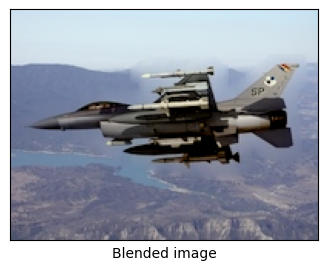

In [18]:
show_images([blend_img],["Blended image"],[5,3])